# Diffusion tensor imaging (DTI)

The diffusion tensor model (Basser et al. 1994) has had huge influence and has propelled the use of DWI. 

The model assumes that diffusion within each voxel can be described as a 3D Gaussian distribution. In this model, the diffusion signal in each voxel and direction is described through a slightly elaborated version of the Stejskal Tanner equation that we saw in the [signal formation](signal-formation.ipynb) notebook:

$S(\theta, b) = S_0 \cdot e^{-b \theta Q \theta^t}$

Where $\theta$ is a direction of measurement, sometimes also referred to as a 'b-vector', b is the b-value described in [signal formation](signal-formation.ipynb) and $Q$ is the diffusion tensor quadratic form, a set of variances and covariances:

$ \left( \begin{array}{ccc}
\sigma^2_x & \sigma_{xy} & \sigma_{xz} \\
\sigma_{yx} & \sigma^2_{y} & \sigma_{yz} \\
\sigma_{zx} & \sigma_{zy} & \sigma^2_{z} \end{array} \right) $

This matrix is a rank 2 tensor, and because diffusion has antipodal symmetry, the covariances across the main diagonal are identical. For example: $\sigma_{xy} = \sigma_{yx}$. 

In [1]:
import os.path as op

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def dti_signal(theta, b, Q, S0=100):
    """ 
    A function to compute the diffusion signal from the DTI model
    
    Parameters
    ----------
    theta : n by 3 array
        The directions to compute the signal.
    
    b : float or array of length n
        The b-value(s) used for the measurement.
    
    Q : 3 by 3 array
        The diffusion tensor, a symmetrical rank 2 tensor.
    
    S0 : float
        The baseline signal, relative to which the signal is computed
    """
    # We take the diagonal of this, because we are only interested in the multiplication of each vector with the 
    # matrix, not in various cross-products:
    adc = np.diag(np.dot(np.dot(theta, Q), theta.T))
    # ADC stands for 'apparent diffusion coefficient', which is an estimate of the diffusivity (in mm^2/s) 
    # in each direction of measurement. We will estimate that later with data
    return S0 * np.exp(-b * adc) 

Let's start with an uninteresting case. Here, the diffusion is *isotropic*, meaning that it is identical in all directions. We compute the signal in 4 different b-vectors, or directions (encoded in `theta`)

In [3]:
Q = np.eye(3)
theta = np.array([[1, 0, 0],  [0, 1, 0],  [0, 0, 1], [1/np.sqrt(2), 1/np.sqrt(2), 0]])
b = 2.0 # We need to scale b to the right units
dti_signal(theta, b, Q)

array([ 13.53352832,  13.53352832,  13.53352832,  13.53352832])

A slightly more interesting case, where diffusion is larger along the x axis than along the y,z axes:

In [4]:
Q = np.array([[1.5, 0, 0], [0, 0.5, 0], [0, 0, 0.5]])
dti_signal(theta, b, Q)

array([  4.97870684,  36.78794412,  36.78794412,  13.53352832])

As expected, the signal is lower for the 'measurement' along the x axis, than for 'measurements' along y or z. The 'measurement' that has a component along x and a component along y lies in between

Because of the antipodal symmetry, estimating the diffusion tensor amounts to fitting 6 independent parameters (3 variances and 3 covariances). 

One of the beautiful things about DTI is that the signal model can be linearized by taking the logarithm of both sides of the equation:

$S(\theta, b) = S_0 \cdot e^{-b \theta Q \theta^t}$

$ \rightarrow log(\frac{S(\theta, b)}{S_0}) =  -b \cdot \theta Q \theta^t $

$ \rightarrow y = X\beta$

Where: 

$ y = log(\frac{S(\theta, b)}{S_0})$

And: 

$X = -b \begin{pmatrix} \theta_{1x}^2 & \theta_{1y}^2 \theta_{1z}^2 & 2\theta_{1x1y} & 2\theta_{1x1z} & 2\theta_{1y1z} & 1 \\ \vdots & \vdots & \vdots & \vdots & \vdots & \vdots \\
\theta_{nx}^2 & \theta_{ny}^2 \theta_{nz}^2 & 2\theta_{nxny} & 2\theta_{nxnz} & 2\theta_{nynz} & 1
\end{pmatrix} $ 

$\beta = \begin{pmatrix} Q_{xx} \\  Q_{yy} \\ Q_{xy}\\ Q_{xz} \\ Q_{yz} \\ log(S_0) \end{pmatrix}$

This allows us to solve for $\beta$ when we have at least 6 diffusion-weighted measurements in different directions.

We will use [`dipy`](http://dipy.org) to perform the fitting. We import a few modules which we will use:

In [5]:
import dipy.reconst.dti as dti 
import dipy.core.gradients as grad
import dipy.core.sphere as sph
import nibabel as nib

First, we simulate noise-free data and assess the fits to this signal. 

We will use the acquisition scheme (b-values and directions) from the data that you [previously downloaded](download-data.ipynb), and store those in a `GradientTable` object, which we will call `gtab`

In [6]:
gtab = grad.gradient_table(op.join('data', 'SUB1_b2000_1.bvals'), op.join('data', 'SUB1_b2000_1.bvecs'))

Simulating the signal using the function that we previously defined, in the 150 diffusion weighting directions that are used in the data, and the 10 non diffusion-weighted directions (sometimes referred to as 'b0' measurements)

In [7]:
sig1 = dti_signal(gtab.bvecs, b, Q)

We plot the signals in the 150 directions:

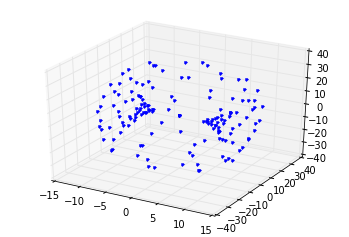

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for ii in range(sig1.shape[0]):
    x,y,z = gtab.bvecs[ii]
    this_sig = np.array([sig1[ii]])
    ax.plot3D(this_sig * x , this_sig * y, this_sig * z, 'b.')

To clearly see the signal in all 150 directions, we also plot it in a linear fashion. Note that the order of the signal along the x-axis in this plot is arbitrary, as it is a reduction of the spherical coordinate frame into a linear coordinate frame. The fist 10 measurements are the non diffusion-weighted measurements, so they are higher than the other measurements and their values are all equal to the default S0 value of 100

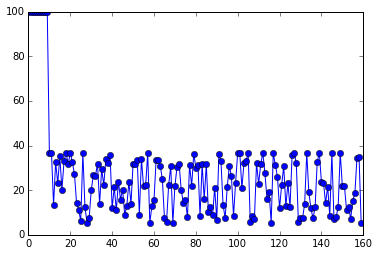

In [9]:
plt.plot(sig1, 'o-')

Next, we fit a model to this signal

In [10]:
model = dti.TensorModel(gtab)
fit = model.fit(sig1)

The model fit recovers the eigenvalues of the tensor that was used to generate the signal:

In [11]:
fit.evals

array([ 0.0015,  0.0005,  0.0005])

The model fit parameters can also be used to predict back the signal that was used:

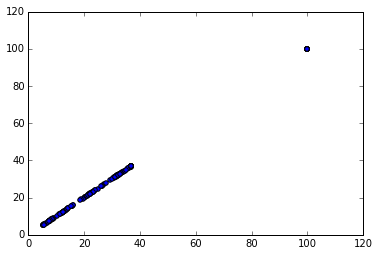

In [12]:
plt.scatter(fit.predict(gtab, S0=100), sig1)

The model predicts the data perfectly, but that is not surprising, considering that the data were generated from this model. 

Now, instead, we will fit the model to data from a single voxel in the MRI measurements

In [13]:
vox_idx = (40, 74, 34)
data1 = nib.load(op.join('data', 'SUB1_b2000_1.nii.gz')).get_data()[vox_idx]

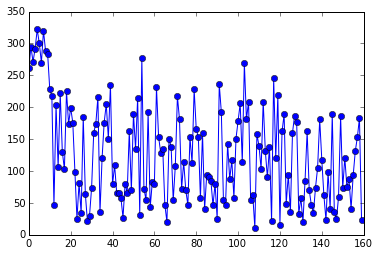

In [14]:
plt.plot(data1, 'o-')

Consider the first 10 measurements, the non diffusion-weighted measurements. The are all higher than the other measurements, but they vary slightly, due to measurement noise. The variance in these measurements gives an indication of the measurement noise. The variance in the diffusion-weighted measurements is due to measurement noise, as well as systematic variance due to different diffusivity in different directions. To assess the relative contribution of these factors to the variance in the signal, we can compare this signal to the measurement in a second data set using the same diffusion-weighting directions, in the same voxel:

In [15]:
data2 = nib.load(op.join('data', 'SUB1_b2000_2.nii.gz')).get_data()[vox_idx]

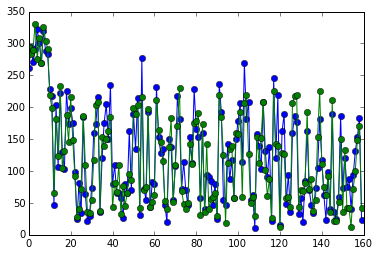

In [16]:
plt.plot(data1, 'o-')
plt.plot(data2, 'o-')

We fit the DTI model to the data from the first measurement:

In [17]:
fit = model.fit(data1)

One common way of interpreting the model tensor parameters is by decomposing the tensor into an eigen-value/-vector decomposition. Hence, we can assess the eigen-values of the diffusion tensor in this voxel:

In [18]:
fit.evals

array([ 0.00143148,  0.00019157,  0.00015346])

From the parameters of the model we can extract useful information. First, we can assess directionally invariant statistics. One useful statistic is the **mean diffusivity** (MD), calculated as the mean of these eigen-values:

In [19]:
fit.md

0.0005921679767965114

The mean diffusivity is sensitive to many biological factors, such as the density of the tissue in this location. 

Another useful statistic that is calculated from the DTI parameters is the **Fractional Anisotropy** (FA). This is calculated as: 

$FA = \sqrt{\frac{1}{2}\frac{(\lambda_1-\lambda_2)^2+(\lambda_1-
                    \lambda_3)^2+(\lambda_2-\lambda_3)^2}{\lambda_1^2+
                    \lambda_2^2+\lambda_3^2}}$
                    
where $\lambda_i$ is the $i^{th}$ eigenvalue of the DTI tensor. FA is also sensitive to a variety of biological factors. This includes the density of the axons in the voxel, the degree to which they are myelinated, and the coherence of the 


In [20]:
fit.fa

0.8671343086424611

From the eigenvectors of the tensor, we extract directional information. For example, the eigenvector corresponding to the largest eigenvalue is the principal diffusion direction, the direction in which there is the largest amount of diffusivity

In [21]:
fit.evecs[0]

array([-0.98303809, -0.02680884,  0.18143153])

In this case, the axis of maximal diffusivity is primarily along the x axis. This information is used to estimate the trajectory of fascicles of nerve fibers through the tissue. We will demonstrate how this is used to generate streamline estimates of these fascicles in the [deterministic tracking](det_track.ipynb) and [probabilistic tracking](prob_track.ipynb) notebooks, pertaining to tractography algorithms.

## How well does the tensor model describe the data?

One important question one might ask is whether the model describes the data well. This can be answered by comparing the prediction of the model to the data

In [22]:
predict1 = fit.predict(gtab, S0=np.mean(data1[:10]))

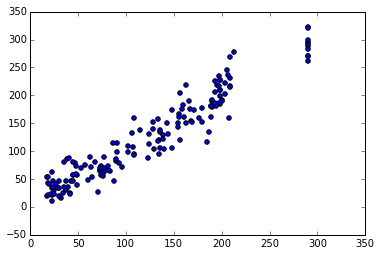

In [23]:
plt.scatter(predict1, data1)

Even better, we can ask whether the model predicts well an independent measurement of the same voxel. This is called cross-validation.

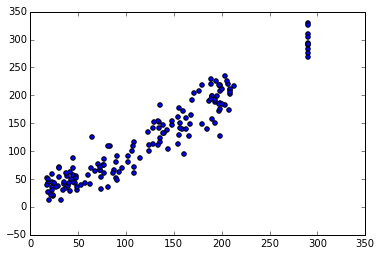

In [24]:
plt.scatter(predict1, data2)

How can we tell whether this is a good fit to the data? One way to assess that is by comparing the goodness of fit of the data to test-retest reliability. The following shows test-retest reliability between the two data-sets:

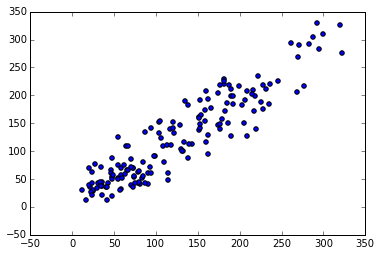

In [25]:
plt.scatter(data1, data2)

Plotted linearily:

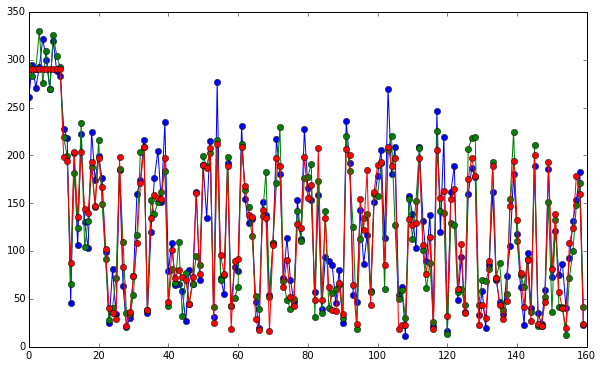

In [26]:
fig, ax = plt.subplots(1)
plt.plot(data1, '-o')
plt.plot(data2, '-o')
plt.plot(predict1, '-o')
fig.set_size_inches([10, 6])

To quantify goodness of fit, relative to test-retest reliability, we compute the distribution of prediction errors and the distribution of test-retest errors:

(array([ 45.,  35.,  22.,  23.,  12.,  14.,   6.,   0.,   1.,   2.]),
 array([  0.14418216,   7.21161125,  14.27904034,  21.34646943,
         28.41389852,  35.48132761,  42.5487567 ,  49.61618579,
         56.68361487,  63.75104396,  70.81847305]),
 <a list of 1 Patch objects>)

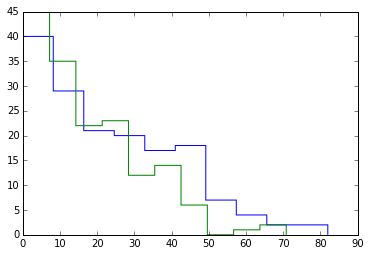

In [27]:
plt.hist(np.abs(data1 - data2), histtype='step')
plt.hist(np.abs(predict1 - data2), histtype='step')

Note that the distribution is shifted to the left (smaller error) for predictions made by the model, relative to test-retest reliability. This is the hallmark of a good model, that it predicts a subsequent data-set even better than the data does.

We can further quantify this by calculating the root of the mean squared error for model predictions, relative to test-retest reliability:

In [28]:
rmse_retest = np.sqrt(np.mean((data1 - data2)**2))
rmse_model = np.sqrt(np.mean((predict1 - data2)**2))
print("Test-retest RMSE: %2.2f"%rmse_retest)
print("Model prediction RMSE: %2.2f"%rmse_model)

Test-retest RMSE: 30.45
Model prediction RMSE: 23.01


We conclude that the DTI model provides a good description of the data. Indeed, the statistics computed from the DTI model (MD, FA, etc.) in different parts of the white matter have been useful markers of variability in many different behavioral measures, and predict differences between individuals with clinical conditions and healthy controls.  